# Tic-Tac-Toe with RL

- The game is played on a grid that's 3 squares by 3 squares.
- Players are "X" and "O".
- Players take turns putting their marks in empty squares.
- The first player to get 3 of her marks in a row (up, down, across, or diagonally) is the winner.
- When all 9 squares are full, the game is over. If no player has 3 marks in a row, the game ends in a tie.



### Environment

- The grid is composed by a magic square [2, 7, 6, 9, 5, 1, 4, 3, 8]
- The idea of the magic square is that each row/column/diagonals sum up to 15

### State

- The state is the set of positions taken by player "X" and player "O"

### Action

- The action is the choice of a number inside the magic square

### Reward

- The reward given to the agent is: 1 if the player wins the game, -1 if it loses and 0.5 if the game is a tie

### Agent

- The agent is a player that uses the Q-Learning logic


Copyright **`(c)`** 2023 Nicolò Caradonna `<s316993@studenti.polito.it>`  
[`https://github.com/Nicocarad/Computational-Intelligence`] 

Sources: https://github.com/squillero/computational-intelligence/blob/master/2023-24/lab10-gx.ipynb , https://gist.github.com/fheisler/430e70fa249ba30e707f

In [193]:
import random
from collections import namedtuple
from itertools import combinations
from random import seed
import matplotlib.pyplot as plt
from tqdm import tqdm

Position = namedtuple("Position", ["x", "o"])

seed(40)




# Game Class
- play_game(): create the logic of the game where "X" and "O" players take turns
- win(): checks if a players has completed a row/column/diagonal (sum to 15)
- board_full(): checks if all the positions have been setted in the board (the game is tie)
- print_board() && print_board_info(): pretty print of the game board


In [194]:
class TicTacToe:
    def __init__(self, playerX, playerO, human_game=False):
        self.board = [2, 7, 6, 9, 5, 1, 4, 3, 8]
        self.current_board = Position(set(), set())
        self.playerX, self.playerO = playerX, playerO
        self.playerX_turn = random.choice([True, False]) #randomly choose who goes first
        self.winner = None
        self.human_game = human_game

    def play_game(self):
        self.playerX.start_game("X")
        self.playerO.start_game("O")
        while True:
            player, char, other_player = (
                (self.playerX, "X", self.playerO)
                if self.playerX_turn
                else (self.playerO, "O", self.playerX)
            )
            
            if self.human_game:
                print(f"Player {char} move")
                self.print_board_info()
                
            move = player.move(self.current_board)
            
            moves = self.current_board.x if self.playerX_turn else self.current_board.o
            moves.add(move)
            if self.human_game:
                self.print_board()

            if self.win(moves):
                player.reward(1, self.current_board)
                other_player.reward(-1, self.current_board)
                self.winner = char
                break

            if self.board_full():  # tie game
                player.reward(0.5, self.current_board)
                other_player.reward(0.5, self.current_board)
                self.winner = None
                break

            other_player.reward(0, self.current_board)
            self.playerX_turn = not self.playerX_turn

    def win(self, state):
        return any(sum(c) == 15 for c in combinations(state, 3))

    def board_full(self):
        player = self.playerX if self.playerX_turn else self.playerO
        return player.available_moves(self.current_board) == set()

    def print_board(self):
        for r in range(3):
            print("-------------")
            for c in range(3):
                i = r * 3 + c
                char = " "
                if self.board[i] in self.current_board.x:
                    char = "X"
                elif self.board[i] in self.current_board.o:
                    char = "O"
                print(f"| {char}", end=" ")
            print("|")
        print("-------------")

    def print_board_info(self):
        for r in range(3):
            print("-------------")
            for c in range(3):
                i = r * 3 + c

                print(f"| {self.board[i]}", end=" ")
            print("|")
        print("-------------")

# Player Class

- The player class is a generic class with some methods to implement the choosing action logic, available moves and also a reward functon if needed
- Random Player class overrides the player class implementing a player that takes action randomly
- Q-Learining Player class overrides the player implementing a RL agent


In [195]:
class Player(object):
    def __init__(self):
        self.name = "human"

    def start_game(self, char):
        print("\nNew game!")

    def move(self, current_board):
       
        move = int(input("Your move? "))
        if move not in self.available_moves(current_board):
            print("Illegal move.")
            move = self.move(current_board)
        return move

    def reward(self, value, current_board):
        print("{} rewarded: {}".format(self.name, value))

    def available_moves(self, current_board):
        available = set(range(1, 9 + 1)) - current_board.x - current_board.o

        return available


class RandomPlayer(Player):
    def __init__(self):
        self.name = "random"

    def reward(self, value, board):
        pass

    def start_game(self, char):
        pass

    def move(self, current_board):
        available = self.available_moves(current_board)
        return random.choice(list(available))


class QLearningPlayer(Player):
    def __init__(self, epsilon=0.2, alpha=0.2, gamma=0.9):
        self.name = "Qlearner"
        self.q = {}  # (state, action) keys: Q values
        self.epsilon = epsilon  # e-greedy chance of random exploration
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor for future rewards

    def start_game(self, char):
        self.last_state = (set(), set())
        self.last_action = None

    def getQ(self, state, action):
        # encourage exploration; "optimistic" 1.0 initial values
        if self.q.get((state, action)) is None:
            self.q[(state, action)] = 1.0
        return self.q.get((state, action))

    def move(self, current_board):
        self.last_state = (
            tuple(current_board.x),
            tuple(current_board.o),
        )  # Convert Position to tuple
        possible_actions = list(self.available_moves(self.last_state))

        if random.random() < self.epsilon: 
            self.last_action = random.choice(list(possible_actions))
            return self.last_action

        qs = [self.getQ(self.last_state, a) for a in possible_actions]
        maxQ = max(qs)

        if qs.count(maxQ) > 1:
            # more than 1 best option; choose among them randomly
            best_options = [i for i in range(len(possible_actions)) if qs[i] == maxQ]
            i = random.choice(best_options)
        else:
            i = qs.index(maxQ)

        self.last_action = possible_actions[i]
        return possible_actions[i]

    def reward(self, value, current_board):
        new_state = (tuple(current_board[0]), tuple(current_board[1]))
        if self.last_action:
            self.learn(
                self.last_state,
                self.last_action,
                value,
                new_state
            )

    def learn(self, state, action, reward, result_state):
        prev = self.getQ(state, action)
        if self.available_moves(result_state) == set():
            self.q[(state, action)] = prev
        else:
            maxqnew = max([self.getQ(result_state, a) for a in self.available_moves(result_state)])
            self.q[(state, action)] = (1-self.alpha)*prev + self.alpha * (
                (reward + self.gamma * maxqnew)
            )

    def available_moves(self, current_board):
        available = set(range(1, 9 + 1)) - set(current_board[0]) - set(current_board[1])
        return available

# Train

- Train the RL agent against a player

In [196]:
def trained_agent(p1, agent, num_games=200000):
    for _ in tqdm(range(0, num_games)):
        t = TicTacToe(p1, agent)
        t.play_game()
    return agent

# Test

- Test the trained agent against a player

In [197]:

agent = trained_agent(RandomPlayer(), QLearningPlayer())
p1 = RandomPlayer()
agent.epsilon = 0 # remove randomness from the trained agent

num_X = 0
num_O = 0
num_ties = 0
for _ in range(100):
    t = TicTacToe(p1, agent)
    t.play_game()
    
    if t.winner == "X":
        num_X += 1
    elif t.winner == "O":
        num_O += 1
    else:
        num_ties += 1

print("X wins: " + str(num_X))
print("O wins: " + str(num_O))
print("Ties: " + str(num_ties))




100%|██████████| 200000/200000 [00:10<00:00, 18668.53it/s]

X wins: 0
O wins: 96
Ties: 4


# Learning process

- The agent is trained for different number of games values
- Higher the number of training games, higher the performance
- Run this part is time consuming (20min on my laptop)


100%|██████████| 200/200 [21:37<00:00,  6.49s/it]


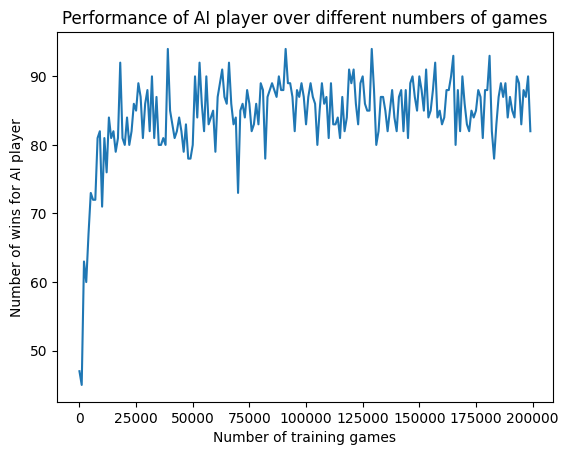

In [198]:
num_train_games_values = list(range(1, 200001, 1000))


results = []
for num in tqdm(num_train_games_values):
    agent = trained_agent(RandomPlayer(), QLearningPlayer(), num)
    p1 = RandomPlayer()
    num_win = 0

    for _ in range(100):
        
        t = TicTacToe(p1, agent)
        t.play_game()
        
        if t.winner == "O":
            num_win += 1
    results.append(num_win)
            


plt.plot(num_train_games_values, results)
plt.xlabel('Number of training games')
plt.ylabel('Number of wins for AI player')
plt.title('Performance of AI player over different numbers of games')
plt.show()

# Plays against AI

- Try to defeat the AI playing a game

In [199]:
human = Player()
t = TicTacToe(human, agent, human_game=True)
print("TIC TAC TOE")
t.print_board_info()
print("-------------------------------")

t.play_game()
print("Winner is: " + str(t.winner))
t.print_board()